# Plotting

> Plotting functions with an example below

In [ ]:
#| default_exp plotting

In [ ]:
#| export
from bivariate_choropleth.grid_palette import GridPalette, BivariateGridPalette, letters
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from string import ascii_uppercase    

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
class BivariateChoropleth:
    "Class for Bivariate Choropleth"
    def __init__(self, gdf:gpd.GeoDataFrame, 
                 x:str, #column name for the x part of the bivariate axis
                 y:str, #column name for the y part of the bivariate axis
                 grid_size:int=3, # grid size, used in pd.cut and GridPalette
                 gp=None, 
                 palette_name='blues2reds'):
        if not isinstance(gdf, gpd.GeoDataFrame):
            raise ValueError('Inputted frame is not a GeoDataFrame')
        
        self.gdf = gdf.loc[:, [x,y, 'geometry']]
        self.x, self.y = x,y
        self.grid_size = grid_size
        self.gdf = self.gdf.pipe(BivariateChoropleth.get_bivar_rank, x, y, grid_size)
        if gp is None:
            self.gp = BivariateGridPalette(palette_name=palette_name, grid_size=grid_size)
        else:
            self.gp = gp
        
    @staticmethod
    def get_bivar_rank(df,x,y,grid_size=3):
        "Create the bivariate ranks. These are of 1A, 3C etc., where y are numbers and x are letters"
        x_ranks = [letters[x] for x in range(grid_size)]
        y_ranks = list(range(1,grid_size+1))
        bivar_ranks = [str(y)+x for y in y_ranks for x in x_ranks]

        x_rank_col=x[:3]+'_rank'
        y_rank_col=y[:3]+'_rank'

        df[x_rank_col] = pd.cut(df[x], grid_size, labels=x_ranks)
        df[y_rank_col] = pd.cut(df[y], grid_size, labels=y_ranks)

        df['bivar_rank'] = df[y_rank_col].astype(str) + df[x_rank_col].astype(str)
        df['bivar_rank'] = pd.Categorical(df.bivar_rank, ordered=True, categories=bivar_ranks)

        return df
    
    def set_defaults(self):
        pass
    
    @staticmethod
    def add_grid_legend(ax=None, gp=None, grid_size=None, palette_name='blues2reds'):
        if grid_size is None:
            # is this a good idea?
            grid_size = globals().get('grid_size', 3)
        if gp is None:
            gp = BivariateGridPalette(palette_name=palette_name, grid_size=grid_size)
        if ax is None:
            ax = plt.gca()

        #TODO: allow this to be changed by user input
        cax = ax.inset_axes([1.1,0,0.2,0.2])
        cax.imshow(gp.color_matrix)
        cax.set_xticks([])
        cax.set_yticks([])
        cax.scatter(-0.5,-0.5, marker='^', color='k', clip_on=False)
        cax.scatter(grid_size-0.5,grid_size-0.5, marker='>', color='k', clip_on=False) 
        return cax
    
    def plot_choropleth_with_grid_legend(self):
        ax = self.gdf.plot(column='bivar_rank', cmap=self.gp.cmap)
        ax.set_axis_off()
        cax = BivariateChoropleth.add_grid_legend(ax, gp=self.gp, grid_size=self.grid_size)
        cax.set_xlabel(self.x)
        cax.set_ylabel(self.y)
        return ax, cax

In [ ]:
#| export
def plot_bivariate_choropleth(
    data: gpd.GeoDataFrame,
    x: str,
    y: str,
    grid_size: int = None,  # Overrides grid_palette size if given
    grid_palette: GridPalette = None,  # Defaults to palette_name
    palette_name: str = 'blues2reds',  # Only used if grid_palette is None
    return_frame: bool = False
) -> plt.Axes:
    """Plotting function for bivariate choropleth."""
    
    if grid_palette is not None:
        if not isinstance(grid_palette, GridPalette):
            print("grid_palette is not GridPalette, using default.")
            grid_palette = None
        else:
            # Use grid_palette's size if grid_size is not provided
            if grid_size is None:
                grid_size = grid_palette.grid_size
            
            # Ensure grid_palette matches the desired grid_size
            if grid_size is not None and grid_palette.grid_size != grid_size:
                print(f"Resizing grid_palette from {grid_palette.grid_size} to {grid_size}.")
                grid_palette.resize(grid_size)
    
    # Final fallback if grid_size is still None
    if grid_size is None:
        grid_size = 3

    choropleth = BivariateChoropleth(
        data, x=x, y=y, grid_size=grid_size, gp=grid_palette, palette_name=palette_name
    )
    ax, cax = choropleth.plot_choropleth_with_grid_legend()

    if return_frame:
        return ax, cax, choropleth.gdf
    return ax, cax


In [ ]:
gp = BivariateGridPalette.from_dropdown()

interactive(children=(Dropdown(description='name', options=('blues2reds', 'purple2gold', 'purple2cyan', 'green…

## An example

In [ ]:
from bivariate_choropleth.shapefiles import load_gdf

load the geodataframe from default path

In [ ]:
ca = load_gdf('ca_counties')
ca = ca.to_crs(epsg=4326)

ca.head()

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,Shape_Leng,Shape_Area,geometry
0,06,091,00277310,06091,Sierra,Sierra County,06,H1,G4020,None,None,None,A,2.468695e+09,2.329911e+07,+39.5769252,-120.5219926,375602.758281,4.200450e+09,"POLYGON ((-120.6556 39.69357, -120.65554 39.69..."
1,06,067,00277298,06067,Sacramento,Sacramento County,06,H1,G4020,472,40900,None,A,2.499984e+09,7.542543e+07,+38.4500161,-121.3404408,406584.174167,4.205516e+09,"POLYGON ((-121.18858 38.71431, -121.18732 38.7..."
2,06,083,00277306,06083,Santa Barbara,Santa Barbara County,06,H1,G4020,None,42200,None,A,7.084063e+09,2.729752e+09,+34.5370572,-120.0399729,891686.747247,1.449841e+10,"MULTIPOLYGON (((-120.7343 34.90069, -120.73431..."
3,06,009,01675885,06009,Calaveras,Calaveras County,06,H1,G4020,None,None,None,A,2.641785e+09,4.384187e+07,+38.1838996,-120.5614415,367005.879680,4.356213e+09,"POLYGON ((-120.63095 38.34111, -120.63058 38.3..."
4,06,111,00277320,06111,Ventura,Ventura County,06,H1,G4020,348,37100,None,A,4.771988e+09,9.473454e+08,+34.3587415,-119.1331432,527772.242190,8.413293e+09,"MULTIPOLYGON (((-119.32923 34.22784, -119.3292..."


In [ ]:
from sklearn.datasets import fetch_california_housing
import shapely
from shapely import Point

process the dataset. Get house prices from the Sklearn dataset. Create a geometry column (Point) with shapely. Perform a spatial join

In [ ]:
housing = fetch_california_housing(as_frame=True)
housing_data = housing.data.join(housing.target)
housing_data['geometry'] = housing_data.apply(lambda x: Point(x.Longitude, x.Latitude), axis=1)

housing_data = gpd.GeoDataFrame(housing_data, geometry='geometry', crs="EPSG:4326") 

housing_data = gpd.sjoin(housing_data, ca, how='left', predicate='within')

get the average per county (index to join on to the spatial data)

In [ ]:
county_level_data = housing_data.groupby('COUNTYNS')[['Population', 'MedHouseVal']].mean()

ca_geo = ca.set_index('COUNTYNS')[['geometry']]
county_level_data = ca_geo.join(county_level_data)

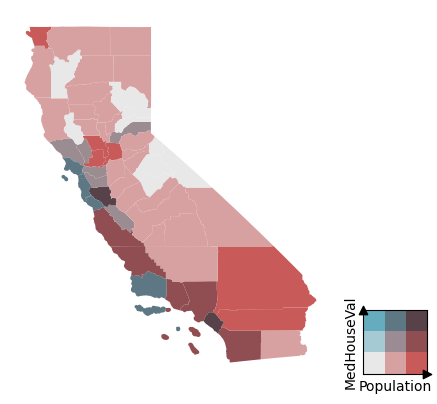

In [ ]:
ax, cax = plot_bivariate_choropleth(county_level_data, y='MedHouseVal', x='Population', grid_palette=gp)

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()